# Computation of Glider Depth Averaged Velocity

jgradone@marine.rutgers.edu     01/11/2022    Initial

This Jupyter Notebook is intended to compute depth averaged velocity per glider segment in a similar manner to Teledyne Webb Research's proprietary algorithm but by utilizing additional more accurate sensors.

**The Depth Averaged Velocity Computed here uses:**<br>
1) Pressure from the glider CTD <br>
2) GPS from the glider <br>
3) Pitch and heading from the Nortek AD2CP AHRS <br>

*Details/comments on what the functions are actually doing in the source code*

In [8]:
# Imports
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from erddapy import ERDDAP
import gsw
import cmocean.cm as cmo
import sys
import dbdreader
import glob

## To import functions from Slocum-AD2CP GitHub repository, make this path the path to where the repo exists locally
sys.path.insert(0,'../src/analysis/')
from analysis import gsw_rho, profile_mld, get_erddap_dataset, grid_glider_data

## Set some plotting formats
plt.style.use('seaborn-poster')
myFmtshort = mdates.DateFormatter('%m/%d\n%H:%M')
myFmtlong = mdates.DateFormatter('%m/%d/%y \n%H:%M')
myFmt = mdates.DateFormatter('%m/%d/%y')

# Load glider data

In [4]:
ds_id = 'ru29-20200908T1623'

variables = ['depth', 'latitude', 'longitude', 'time', 'temperature', 'salinity', 'pressure', 'density','profile_id']

## To use this, need to add        ds = e.to_pandas().dropna(how='all') to get_erddap_dataset()
#variables = ['depth', 'latitude', 'longitude', 'time', 'temperature', 'salinity', 'density','profile_id','measured_water_vx','measured_water_vy']

glider_df = get_erddap_dataset(ds_id, variables = variables, filetype='dataframe')
glider_df.columns = variables
glider_df

,depth,latitude,longitude,time,temperature,salinity,pressure,density,profile_id
0,6.291905,18.176894,-64.805169,2020-09-08T16:34:05Z,29.6361,34.923676,6.33,1021.81995,1599582843
1,8.319587,18.176894,-64.805169,2020-09-08T16:34:05Z,29.5950,34.931324,8.37,1021.84830,1599582843
2,10.963495,18.176894,-64.805169,2020-09-08T16:34:05Z,29.5569,34.944120,11.03,1021.88220,1599582843
3,13.557673,18.176894,-64.805169,2020-09-08T16:34:05Z,29.5177,34.995190,13.64,1021.94495,1599582843
4,16.181635,18.176894,-64.805169,2020-09-08T16:34:05Z,29.4944,35.054394,16.28,1022.00850,1599582843
...,...,...,...,...,...,...,...,...,...
760659,10.506288,18.163999,-64.789748,2020-11-16T12:51:14Z,28.0102,34.743640,10.57,1022.24475,1605500363
760660,9.005423,18.163999,-64.789748,2020-11-16T12:51:14Z,28.0101,34.743526,9.06,1022.23820,1605500363
760662,7.385271,18.163999,-64.789748,2020-11-16T12:51:14Z,28.0103,34.743300,7.43,1022.23100,1605500363
760663,5.635891,18.163999,-64.789748,2020-11-16T12:51:14Z,28.0107,34.743176,5.67,1022.22320,1605500363


In [6]:
## This is a really good way to find start and end times
start_times = glider_df.groupby('profile_id').first().time.values
end_times   = glider_df.groupby('profile_id').last().time.values

## Figure from Teledyne Webb Research documentation on water velocity calculation

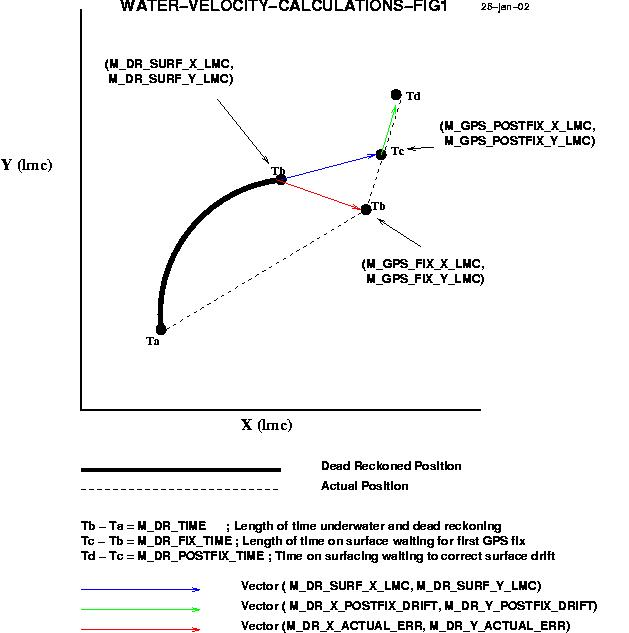

In [2]:
glpath = '/Users/joegradone/SynologyDrive/Drive/Rutgers/Misc/Antarctica/NOAA_Glider_Deployment/amlr05_data/'
glfiles = 
cachepath = '/Users/joegradone/SynologyDrive/Drive/Rutgers/Misc/Antarctica/NOAA_Glider_Deployment/amlr05_data/'

# Load dbd class
dbd = dbdreader.MultiDBD(pattern=glpath+"*.[ED]BD",cacheDir=cachepath)

dr_eptime, Vx, Vy, lat, lon = dbd.get_sync("m_water_vx", "m_water_vy m_gps_lat m_gps_lon".split())

tm,depth,lat,lon =dbd.get_sync("m_depth","m_lat","m_lon")


INFO:dbdreader.py:Calling signature of get_sync() has changed in version 0.4.0.


In [11]:
glfiles = np.sort(glob.glob(glpath+'*.DBD'))


In [26]:
dbd = dbdreader.DBD(glfiles[10],cacheDir=cachepath)
#tm,depth,lat,lon =dbd.get_sync("m_dr")
t,drtm = dbd.get("m_dr_time")
drtm

array([-1.00000000e+00, -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
       -1.00000000e+00, -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
       -1.00000000e+00, -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
       -1.00000000e+00, -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
       -1.00000000e+00, -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
       -1.00000000e+00, -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
       -1.00000000e+00, -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
       -1.00000000e+00, -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
       -1.00000000e+00,  5.58323584e+03, -1.00000000e+00, -1.00000000e+00,
       -1.00000000e+00, -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
       -1.00000000e+00, -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
       -1.00000000e+00, -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
       -1.00000000e+00, -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
       -1.00000000e+00, -